# Preparation of dataset for Elemental Descriptor

In [1]:
import tpot
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import pandas as pd
import matplotlib.pyplot as plt
import chemparse
from matplotlib.patches import Rectangle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.svm import SVR
import matplotlib
from sklearn.decomposition import PCA
import pandas as pd
import chemparse
import os

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-12.6-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas 1.4.2
Scikit-Learn 1.0.2
GPU is available


# Analysis of the descriptor

In [2]:
descriptor = pd.read_csv(r'output.csv', header = None, sep = "\s+|\t+|\s+\t+|\t+\s+", engine='python')
desc_only = descriptor.iloc[:, 1:-1] ## properties_A, X_A, properties_B, X_B (16 each), where X_A weighted are properties of elements

# original order in the output.csv file:
#                A1       B1      A1/B1             A1*B1     
# ionic radii   1.035  0.8525 1.2140762463343107  0.8823375 
# idbond         2.2     2.0      1.1                4.4
# electronegativity 2.02 1.83 1.1038251366120218 3.6966
# vwd            2.07 2.04 1.0147058823529411 4.222799999999999
# ion E          7.285516 17.9024681 0.9219291881735024 57.5735577820396
# molar V          21.31 7.09        3.005641748942172 151.0879
# atomic number    83.0 26.0 3.1923076923076925 2158.0
# atomic mass    208.9804  55.845 3.742150595397977 11670.510438 

In [152]:
descriptor.iloc[:, 0:1]

,0
0,(Bi100.0)(Ca100.0)(Fe100.0)()X3
1,(Bi95.0)(Ca5.0)(Fe100.0)()X3
2,(Bi90.0)(Ca10.0)(Fe100.0)()X3
3,(Bi85.0)(Ca15.0)(Fe100.0)()X3
4,(Bi80.0)(Ca20.0)(Fe100.0)()X3
...,...
80,(Ca200.0)()(Fe100.0)(Bi100.0)X3
81,(Ca200.0)()(Sm100.0)(Bi100.0)X3
82,(Ca200.0)()(Dy100.0)(Bi100.0)X3
83,(Ca200.0)()(Fe100.0)(Bi100.0)X3


Text(0.5, 1.0, '        A1     A2    B1     B2    A1/B1 A2/B2 A1*B1 A2*B2')

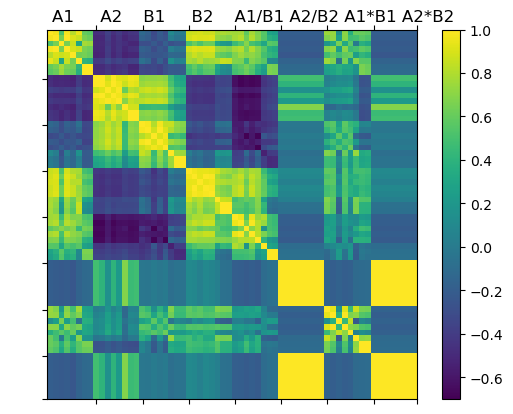

In [3]:
# Just for visualization - legacy code
# rearranged into: A1   A2    B1  B2  A1/B1   A2/B2  A1*B1  A2*B2
desc_only_rearranged = desc_only[[1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, #A1 A2
                                  2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, #B1 B2
                                  3,  7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, # A1/B1 A2/B2
                                  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]] # A1*B1 A2*B2

figure = plt.figure()
axes = figure.add_subplot(111)

caxes = axes.matshow(desc_only_rearranged.corr())
figure.colorbar(caxes)

ticks = [8, 16, 24, 32, 40, 48, 56, 63.5]
axes.set_xticks(ticks)
axes.set_yticks(ticks)
axes.set_xticklabels(['' , '' , '' , '' , '' , '' , '' , '' , ])
axes.set_yticklabels(['' , '' , '' , '' , '' , '' , '' , '' , ])
axes.set_title('        A1     A2    B1     B2    A1/B1 A2/B2 A1*B1 A2*B2')

In [4]:
# naming the columns in the desc_only dataframe
counter = 0

for properties in ("'ionic_radii_", "'ideal_X-O_bond_", "'electronegativity_", "'vdW_radius_",
                   "'ionization_E_", "'Molar_V_", "'Atomic_#_", "'Atomic_mass_"):
    for site in ('A1', 'B1', 'A1/B1', 'A1*B1'):
        counter = counter + 1
#        print (str(counter)+': '+properties+site+"',")
    
for properties in ("'ionic_radii_", "'ideal_X-O_bond_", "'electronegativity_", "'vdW_radius_",
                   "'ionization_E_", "'Molar_V_", "'Atomic_#_", "'Atomic_mass_"):
    for site in ('A2', 'B2', 'A2/B2', 'A2*B2'):
        counter = counter + 1
#        print (str(counter)+': '+properties+site+"',")

In [5]:
desc_only_named = desc_only.rename({
1: 'ionic_radii_A1', 2: 'ionic_radii_B1',  3: 'ionic_radii_A1/B1',  4: 'ionic_radii_A1*B1', 5: 'ideal_X-O_bond_A1',
6: 'ideal_X-O_bond_B1', 7: 'ideal_X-O_bond_A1/B1',  8: 'ideal_X-O_bond_A1*B1',  9: 'electronegativity_A1',
10: 'electronegativity_B1', 11: 'electronegativity_A1/B1', 12: 'electronegativity_A1*B1',
13: 'vdW_radius_A1', 14: 'vdW_radius_B1', 15: 'vdW_radius_A1/B1', 16: 'vdW_radius_A1*B1',
17: 'ionization_E_A1', 18: 'ionization_E_B1', 19: 'ionization_E_A1/B1', 20: 'ionization_E_A1*B1',
21: 'Molar_V_A1', 22: 'Molar_V_B1', 23: 'Molar_V_A1/B1', 24: 'Molar_V_A1*B1', 25: 'Atomic_#_A1', 26: 'Atomic_#_B1',
27: 'Atomic_#_A1/B1', 28: 'Atomic_#_A1*B1', 29: 'Atomic_mass_A1',  30: 'Atomic_mass_B1', 31: 'Atomic_mass_A1/B1',
32: 'Atomic_mass_A1*B1', 33: 'ionic_radii_A2',  34: 'ionic_radii_B2', 35: 'ionic_radii_A2/B2', 36: 'ionic_radii_A2*B2',
37: 'ideal_X-O_bond_A2', 38: 'ideal_X-O_bond_B2', 39: 'ideal_X-O_bond_A2/B2', 40: 'ideal_X-O_bond_A2*B2', 41: 'electronegativity_A2',
42: 'electronegativity_B2', 43: 'electronegativity_A2/B2', 44: 'electronegativity_A2*B2', 45: 'vdW_radius_A2',
46: 'vdW_radius_B2',  47: 'vdW_radius_A2/B2', 48: 'vdW_radius_A2*B2', 49: 'ionization_E_A2', 50: 'ionization_E_B2',
51: 'ionization_E_A2/B2',  52: 'ionization_E_A2*B2', 53: 'Molar_V_A2',  54: 'Molar_V_B2', 55: 'Molar_V_A2/B2',
56: 'Molar_V_A2*B2', 57: 'Atomic_#_A2',  58: 'Atomic_#_B2', 59: 'Atomic_#_A2/B2', 60: 'Atomic_#_A2*B2', 61: 'Atomic_mass_A2',
62: 'Atomic_mass_B2', 63: 'Atomic_mass_A2/B2', 64: 'Atomic_mass_A2*B2',
}, axis=1)

desc_only_named # named dataframe

,ionic_radii_A1,ionic_radii_B1,ionic_radii_A1/B1,ionic_radii_A1*B1,ideal_X-O_bond_A1,ideal_X-O_bond_B1,ideal_X-O_bond_A1/B1,ideal_X-O_bond_A1*B1,electronegativity_A1,electronegativity_B1,...,Molar_V_A2/B2,Molar_V_A2*B2,Atomic_#_A2,Atomic_#_B2,Atomic_#_A2/B2,Atomic_#_A2*B2,Atomic_mass_A2,Atomic_mass_B2,Atomic_mass_A2/B2,Atomic_mass_A2*B2
0,1.03500,0.8525,1.214076,0.882337,2.20,2.00,1.100000,4.40,2.020,1.83,...,0.0,0.0,20.0,0.0,0.0,0.0,40.0780,0.0000,0.0,0.0
1,0.98325,0.8525,1.153372,0.838221,2.09,2.00,1.045000,4.18,1.919,1.83,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0039,0.0000,0.0,0.0
2,0.93150,0.8525,1.092669,0.794104,1.98,2.00,0.990000,3.96,1.818,1.83,...,0.0,0.0,2.0,0.0,0.0,0.0,4.0078,0.0000,0.0,0.0
3,0.87975,0.8525,1.031965,0.749987,1.87,2.00,0.935000,3.74,1.717,1.83,...,0.0,0.0,3.0,0.0,0.0,0.0,6.0117,0.0000,0.0,0.0
4,0.82800,0.8525,0.971261,0.705870,1.76,2.00,0.880000,3.52,1.616,1.83,...,0.0,0.0,4.0,0.0,0.0,0.0,8.0156,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2.28000,0.8525,2.674487,1.943700,4.80,2.00,2.400000,9.60,2.000,1.83,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0
81,2.28000,1.2290,1.855167,2.802120,4.80,2.45,1.959184,11.76,2.000,1.17,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0
82,2.28000,1.1310,2.015915,2.578680,4.80,2.35,2.042553,11.28,2.000,1.22,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0
83,2.28000,0.8525,2.674487,1.943700,4.80,2.00,2.400000,9.60,2.000,1.83,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0


In [6]:
# Visual check that the first compund is right:
#                A1       B1      A1/B1             A1*B1     
# ionic radii   1.035  0.8525 1.2140762463343107  0.8823375 
# idbond         2.2     2.0      1.1                4.4
# electronegativity 2.02 1.83 1.1038251366120218 3.6966
# vwd            2.07 2.04 1.0147058823529411 4.222799999999999
# ion E          7.285516 17.9024681 0.9219291881735024 57.5735577820396
# molar V          21.31 7.09        3.005641748942172 151.0879
# atomic number    83.0 26.0 3.1923076923076925 2158.0
# atomic mass    208.9804  55.845 3.742150595397977 11670.510438 

[Text(0, 7.5, ''),
 Text(0, 15.5, ''),
 Text(0, 23.5, ''),
 Text(0, 31.5, ''),
 Text(0, 39.5, ''),
 Text(0, 47.5, ''),
 Text(0, 55.5, ''),
 Text(0, 63.5, '')]

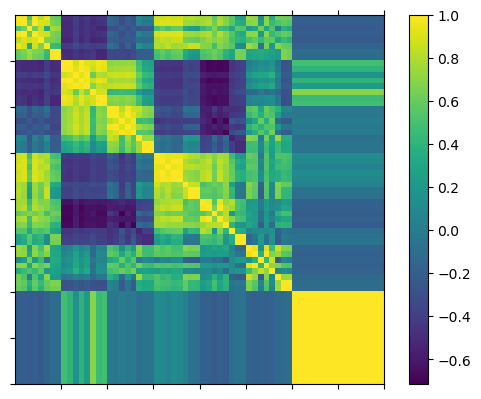

In [7]:
# delete A2/B2 and A2*B2
# graph = desc_only_named.loc[:,~desc_only_named.columns.str.endswith('A2/B2')]
# graph_withoutA2B2_comb = graph.loc[:,~graph.columns.str.endswith('A2*B2')]

# reorder the columns:
one = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A1')]
two = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A2')]
three = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_B1')]
four = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_B2')]
five = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A1/B1')]
six = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A1*B1')]
seven = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A2/B2')]
eight = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A2*B2')]

desc_only_A1A2B1B2A1B1A2B2 = pd.concat([one, two, three, four, five, six, seven, eight], axis=1)


# visualize the correlations of the columns:
figure = plt.figure()
axes = figure.add_subplot(111)

#caxes = axes.matshow(matrix_plt[~desc_only_A1A2B1B2divProd.duplicated()].corr())
caxes = axes.matshow(desc_only_A1A2B1B2A1B1A2B2[~desc_only_A1A2B1B2A1B1A2B2.duplicated()].corr())
figure.colorbar(caxes)

ticks = [7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5, 63.5]
axes.set_xticks(ticks)
axes.set_yticks(ticks)
axes.set_xticklabels(['' , '' , '' , '' , '' , '', '' , ''])
axes.set_yticklabels(['' , '' , '' , '' , '' , '', '' , ''])

In [8]:
desc_only_A1A2B1B2A1B1A2B2 # it is the same as desc_only_rearranged just named, 64 columns

,ionic_radii_A1,ideal_X-O_bond_A1,electronegativity_A1,vdW_radius_A1,ionization_E_A1,Molar_V_A1,Atomic_#_A1,Atomic_mass_A1,ionic_radii_A2,ideal_X-O_bond_A2,...,Atomic_#_A2/B2,Atomic_mass_A2/B2,ionic_radii_A2*B2,ideal_X-O_bond_A2*B2,electronegativity_A2*B2,vdW_radius_A2*B2,ionization_E_A2*B2,Molar_V_A2*B2,Atomic_#_A2*B2,Atomic_mass_A2*B2
0,1.03500,2.20,2.020,2.0700,7.285516,21.3100,83.00,208.98040,1.140,2.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.98325,2.09,1.919,1.9665,6.921240,20.2445,78.85,198.53138,0.057,0.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.93150,1.98,1.818,1.8630,6.556964,19.1790,74.70,188.08236,0.114,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.87975,1.87,1.717,1.7595,6.192689,18.1135,70.55,177.63334,0.171,0.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.82800,1.76,1.616,1.6560,5.828413,17.0480,66.40,167.18432,0.228,0.48,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Simple correlation matrix plot for A1 features:

In [9]:
#pd.plotting.scatter_matrix(desc_only.iloc[:, [0, 4, 8, 12, 16, 20, 24, 28]], alpha=0.2, figsize=(8, 8))

Histograms showing the zero features:

array([[<AxesSubplot: title={'center': '1'}>,
        <AxesSubplot: title={'center': '2'}>,
        <AxesSubplot: title={'center': '3'}>,
        <AxesSubplot: title={'center': '4'}>],
       [<AxesSubplot: title={'center': '5'}>,
        <AxesSubplot: title={'center': '6'}>,
        <AxesSubplot: title={'center': '7'}>,
        <AxesSubplot: title={'center': '8'}>],
       [<AxesSubplot: title={'center': '9'}>,
        <AxesSubplot: title={'center': '10'}>,
        <AxesSubplot: title={'center': '11'}>,
        <AxesSubplot: title={'center': '12'}>],
       [<AxesSubplot: title={'center': '13'}>,
        <AxesSubplot: title={'center': '14'}>,
        <AxesSubplot: title={'center': '15'}>,
        <AxesSubplot: title={'center': '16'}>],
       [<AxesSubplot: title={'center': '17'}>,
        <AxesSubplot: title={'center': '18'}>,
        <AxesSubplot: title={'center': '19'}>,
        <AxesSubplot: title={'center': '20'}>],
       [<AxesSubplot: title={'center': '21'}>,
        <AxesSubp

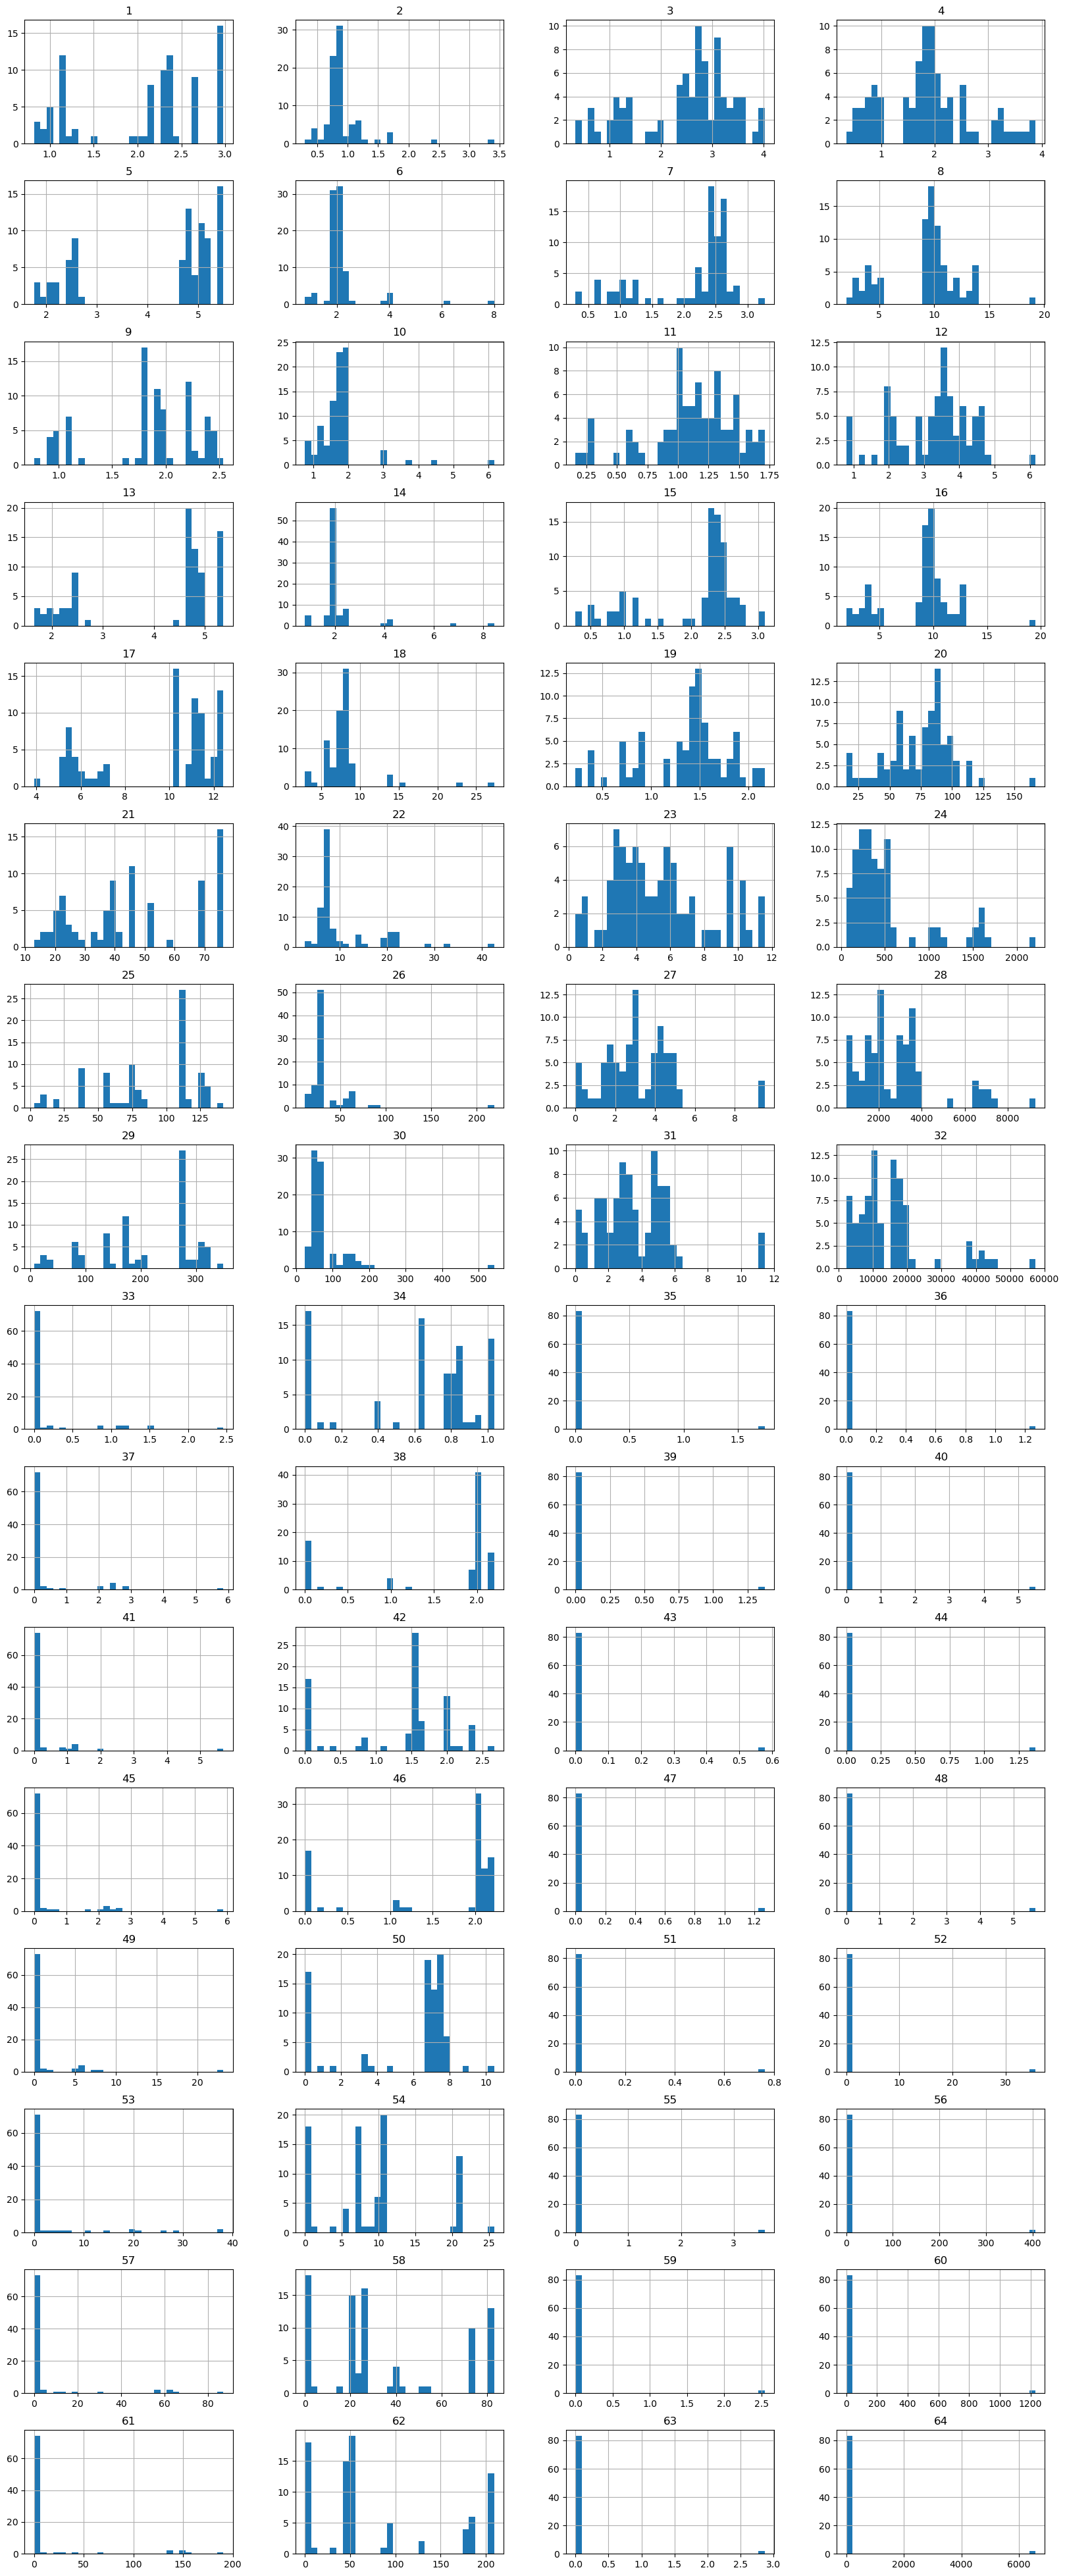

In [35]:
desc_only.hist(figsize = (20, 50), layout = (16, 4), bins=30)

Reading of elemental weight composition:

In [11]:
df = pd.read_excel(r'/Users/hostas/Documents/01-Analysis/2022-11-06 Perovskites/perovskites.xlsx')

cleaned = pd.DataFrame()
cleaned['Chemical Formula']=df['Chemical Formula']
cleaned['Chemical Formula Dictionary']=df['Chemical Formula']
lenght=len(cleaned['Chemical Formula'])

for row in range(lenght):
    cleaned['Chemical Formula Dictionary'][row]= chemparse.parse_formula(cleaned['Chemical Formula'][row])
    
matrix = cleaned['Chemical Formula Dictionary'].apply(pd.Series)
matrix['sum'] = matrix.sum(axis = 1)
wlenght=len(matrix.columns)

for col in range(wlenght):
    matrix.iloc[:, col] = matrix.iloc[:, col] / matrix['sum']
        
compositions = matrix.drop(columns='sum').fillna(0)
non_weight_compositions = compositions.copy()
# non_weight_compositions

#Data for elemental weights, source: https://www.angelo.edu/faculty/kboudrea/periodic/structure_mass.htm
elements = ['O', 'La', 'Ba', 'Fe', 'Bi', 'Sr', 'Ti', 'Mn', 'Ca', 'Ni', 'Gd', 'Co', 'Dy', 'Ta', 'Nb', 'W', 'Zn', 'Eu', 'Pr', 'Sm', 'Mg', 'Cr', 'Na', 'In', 'Cu', 'Lu', 'Tb', 'Y', 'Te', 'Ga', 'Nd', 'Ag', 'Ce', 'V', 'I', 'Mo', 'Sc', 'Al', 'Li']
weights = [15.9994, 138.9055, 137.33, 55.847, 208.9804, 87.62, 47.90, 54.9380, 40.08, 58.70, 157.25, 58.9332, 162.50, 180.9479, 92.9064, 183.85, 65.38, 151.96, 140.9077, 150.4, 24.305, 51.996, 22.98977, 114.82, 63.546, 174.967, 158.9254, 88.9059, 127.60, 69.72, 144.24, 107.868, 140.12, 50.9415, 126.9045, 95.94, 44.9559, 26.98154, 6.941]

elemental_weight = dict(zip(elements, weights))

# Change to weight composition
counter = -1

for col in compositions.columns:
    counter+=1
    element = col
    compositions.iloc[:, counter] = compositions.iloc[:, counter] * elemental_weight[col]

lenght=len(compositions['Bi'])

compositions['sum'] = compositions.sum(axis = 1)
wlenght=len(compositions.columns)

for col in range(wlenght):
    compositions.iloc[:, col] = compositions.iloc[:, col] / compositions['sum']
        
weight_compositions = compositions.drop(columns='sum')


weight_compositions_NaN = weight_compositions.copy()
weight_compositions_NaN['Bandgap'] = df.iloc[:, 21]
weight_compositions_NaN = weight_compositions_NaN.dropna()


non_zero_weights = weight_compositions[weight_compositions > 0].count().sort_values(ascending=False)#.iloc[0:11]

del[[matrix, counter, cleaned, elements, weights]]
# compositions
# weight_compositions
# weight_compositions_NaN
# elemental_weight
# non_zero_weights

In [219]:
compositions.iloc[0:1, :]

,Bi,Ca,Fe,O,Gd,Cr,Sr,Ta,Ni,Mo,...,V,Ce,Nd,In,Te,Ga,Tb,Y,Al,sum
0,0.592171,0.113571,0.158249,0.136009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [220]:
weight_compositions.iloc[0:1, :]

,Bi,Ca,Fe,O,Gd,Cr,Sr,Ta,Ni,Mo,...,Pr,V,Ce,Nd,In,Te,Ga,Tb,Y,Al
0,0.592171,0.113571,0.158249,0.136009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
mass_test = 208.9804/2+40.08/2+55.847+15.9994*3
mass_test

228.3754

In [228]:
208.9804/2/mass_test # bi

0.4575370201869378

In [235]:
# [         Bi,       Ca,       Fe,           O,          Gd,  ...]
# [   208.9804,    40.08,   55.847,     15.9994,      157.25, … ]

208.9804/2/(208.9804/2+40.08/2+55.847+15.9994*3) # bi 0.4575370201869378

0.4575370201869378

In [232]:
40.08/2/(208.9804/2+40.08/2+55.847+15.9994*3) # Ca 0.0877502568140001

0.0877502568140001

In [233]:
55.847/(208.9804/2+40.08/2+55.847+15.9994*3) # Fe 0.2445403489167397

0.2445403489167397

In [234]:
15.9994*3/(208.9804/2+40.08/2+55.847+15.9994*3) # O 0.21017237408232234

0.21017237408232234

Just a test with Iron that the reading of bandgap/weight compositions work:

In [12]:
# element=['Fe']; color=['orange']
# plt.hist(weight_compositions[element], color=color, edgecolor='black', bins=int(10/1))
# plt.xlabel('Composition / wt.%'); plt.ylabel('No. compounds')
# plt.title(str(non_zero_weights[element][0])+' compounds with '+str(element[0]))
# plt.ylim([0, 80])
# cmap = plt.get_cmap('jet'); low = cmap(0.5)
# handles = [Rectangle((0,0),1,1, color=color[0], ec="k") for c in element]; labels= element
# plt.legend(handles, labels)

Including Crystal system and Sample prep:

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore'); additional = pd.DataFrame()

additional['Crystal system'] = df['Crystal system'].str.lower().str.strip()
additional['Sample preparation'] = df['Sample preparation'].str.lower().str.strip() # additional['Sample preparation'].unique()
newones = pd.get_dummies(additional['Crystal system'])
newones2 = pd.get_dummies(additional['Sample preparation'])
crystal_and_sample = pd.concat([newones, newones2], axis = 1)

In [14]:
print ('shape of desc_only_A1A2B1B2A1B1A2B2: ', desc_only_A1A2B1B2A1B1A2B2.shape)
print ('shape of crystal_and_sample: ', crystal_and_sample.shape)
print ('shape of weight_compositions: ', weight_compositions.shape)
print ('shape of bandgap vector: ', df.iloc[:, 21].shape)
print ('combining together into master_database and striping duplicates into master_database_wo_duplicates')

shape of desc_only_A1A2B1B2A1B1A2B2:  (85, 64)
shape of crystal_and_sample:  (85, 22)
shape of weight_compositions:  (85, 39)
shape of bandgap vector:  (85,)
combining together into master_database and striping duplicates into master_database_wo_duplicates


In [15]:
#desc_only_A1A2B1B2divProd # descriptor 85 x 48 with column elemental property names
master_database = pd.concat([desc_only_A1A2B1B2A1B1A2B2, crystal_and_sample, weight_compositions], axis=1)
master_database['Bandgap'] = df.iloc[:, 21]

master_database_wo_duplicates = master_database[~desc_only_A1A2B1B2A1B1A2B2.duplicated()].dropna()

master_database_wo_duplicates_std = StandardScaler().fit_transform(master_database_wo_duplicates.iloc[:, :-1])
Bandgap_54x = master_database_wo_duplicates['Bandgap']

In [42]:
print ('shape of master_database_wo_duplicates: ', master_database_wo_duplicates.shape)

shape of master_database_wo_duplicates:  (54, 126)


Calculating non zero weights and plotting compounds with the most abundant elements:

In [76]:
weight_md_wo_dupl = master_database_wo_duplicates.iloc[:, 86:-1]
non_zero_weights_wo_dupls = weight_md_wo_dupl[weight_md_wo_dupl > 0].count().sort_values(ascending=False)
#non_zero_weights_wo_dupls.iloc[0:5]

In [72]:
# element=['Ba']; color=['green']
# element=['Fe']; color=['orange']
# element=['O']; color=['gray']
# element=['Sr']; color=['blue']

# plt.hist(master_database_wo_duplicates[element], color=color, edgecolor='black', bins=int(10/1))
# plt.xlabel('Composition / wt.%'); plt.ylabel('No. compounds')
# plt.title(str(non_zero_weights_wo_dupls[element][0])+' compounds with '+str(element[0]))
# plt.ylim([0, 50])
# cmap = plt.get_cmap('jet'); low = cmap(0.5)
# handles = [Rectangle((0,0),1,1, color=color[0], ec="k") for c in element]; labels= element
# plt.legend(handles, labels)

In [83]:
# plt.hist(master_database_wo_duplicates['Bandgap'], color='pink', edgecolor='black', bins=int(10/1))
# plt.xlabel('Bandgap in [eV]'); plt.ylabel('No. compounds')
# plt.title('Bandgap for 54 compounds')
# plt.ylim([0, 20])

In [87]:
# elements_in_md_dataset=weight_md_wo_dupl[weight_md_wo_dupl > 0].count().sort_values(ascending=False).iloc[1:-9]
# matplotlib.rcParams['font.size'] = 15
# matplotlib.rcParams['figure.dpi'] = 100
# fig = plt.figure(figsize = (10,7))
# elements_in_md_dataset.plot(kind='bar', title='Number of Perovskites')#, yticks=[10, 40, 80])

[Text(0, 7.5, ''),
 Text(0, 15.5, ''),
 Text(0, 23.5, ''),
 Text(0, 31.5, ''),
 Text(0, 39.5, ''),
 Text(0, 47.5, ''),
 Text(0, 55.5, ''),
 Text(0, 63.5, '')]

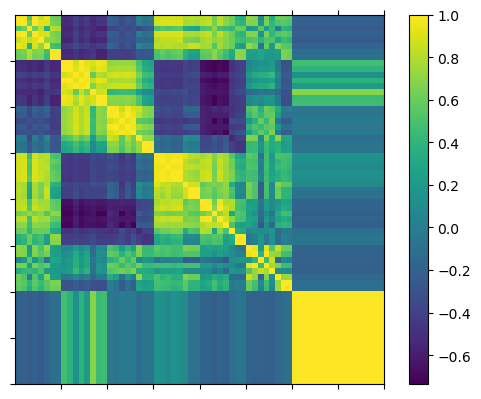

In [18]:
# visualize the correlations of the columns:
figure1 = plt.figure()
axes1 = figure1.add_subplot(111)

caxes = axes1.matshow(master_database_wo_duplicates.iloc[:, 0:64].corr())
figure1.colorbar(caxes)

ticks = [7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5, 63.5]
axes1.set_xticks(ticks)
axes1.set_yticks(ticks)
axes1.set_xticklabels(['' , '' , '', '', '' , '', '' , ''])
axes1.set_yticklabels(['' , '' , '', '', '' , '', '' , ''])

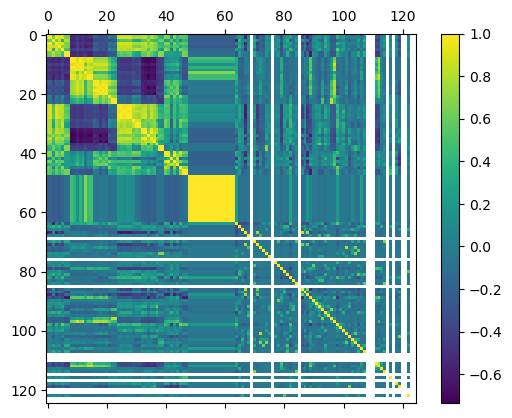

In [30]:
figure2 = plt.figure()
axes2 = figure2.add_subplot(111)

caxes = axes2.matshow(master_database_wo_duplicates.iloc[:, 0:-1].corr())
figure2.colorbar(caxes)

# ticks = [7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5, 63.5]
# axes2.set_xticks(ticks)
# axes2.set_yticks(ticks)
# axes1.set_xticklabels(['' , '' , '', '', '' , '', '' , ''])
# axes1.set_yticklabels(['' , '' , '', '', '' , '', '' , ''])

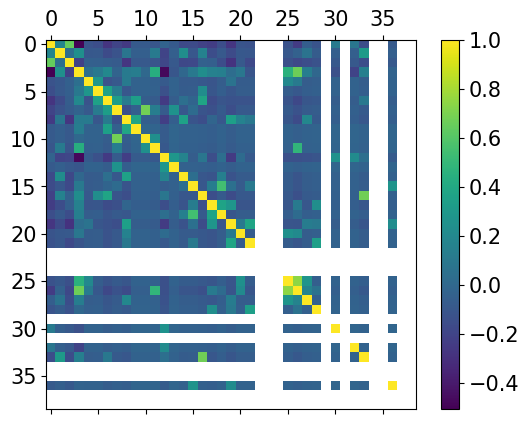

In [170]:
figure2 = plt.figure()
axes2 = figure2.add_subplot(111)

caxes = axes2.matshow(master_database_wo_duplicates.iloc[:, 86:-1].corr())
figure2.colorbar(caxes)

In [174]:
master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].columns

Index(['Bi', 'Ca', 'Fe', 'O', 'Gd', 'Cr', 'Sr', 'Ta', 'Ni', 'Mo', 'Li', 'Cu',
       'Ba', 'Sc', 'W', 'Co', 'Nb', 'La', 'Mg', 'Mn', 'Eu', 'Dy', 'Na', 'Ti',
       'Sm', 'Zn', 'V', 'Nd', 'In', 'Tb'],
      dtype='object')

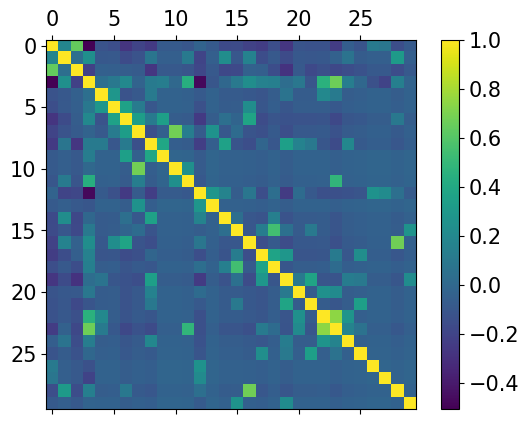

In [175]:
figure2 = plt.figure()
axes2 = figure2.add_subplot(111)

caxes = axes2.matshow(master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].corr())
figure2.colorbar(caxes)

# Regression on all Elemental features

Mean squared error: 0.002
Median squared error: 0.000
Coefficient of determination: 0.997


Text(0.5, 1.0, 'Linear Regression directly on 48 features')

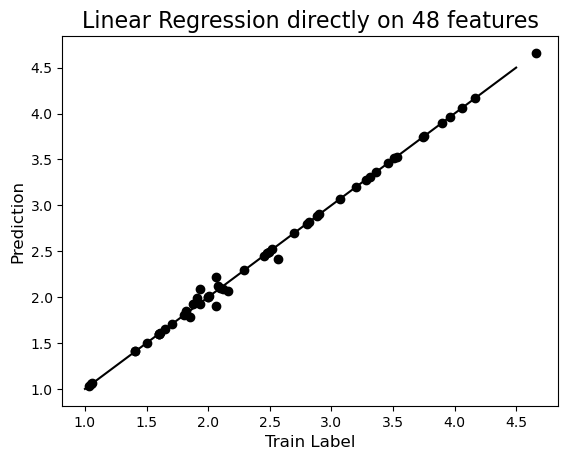

In [91]:
x = master_database_wo_duplicates_std[:, :48]
y = Bandgap_54x

regr = linear_model.LinearRegression()
regr.fit(x, y) # shape 60x64 and 60x1

test_lbl_pred = regr.predict(x)

print("Mean squared error: %.3f" % mean_squared_error(y, test_lbl_pred)); print("Median squared error: %.3f" % median_absolute_error(y, test_lbl_pred)); print("Coefficient of determination: %.3f" % r2_score(y, test_lbl_pred))

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-') ; plt.xlabel('Train Label', fontsize = 12); plt.ylabel('Prediction', fontsize = 12); plt.title('Linear Regression directly on '+ str(x.shape[1]) +' features', fontsize = 16)

Above is how the results of linear regression look like for training. Next, we will look on leave-one-out performance on test data. In leave one out method, we train as many models as there are data in the dataset and train on all data points but one which is left for testing. Results are bellow:

Mean squared error: 27076540362745811304448.000
Median squared error: 3069203327.476
Coefficient of determination: -34680424027722220568576.000


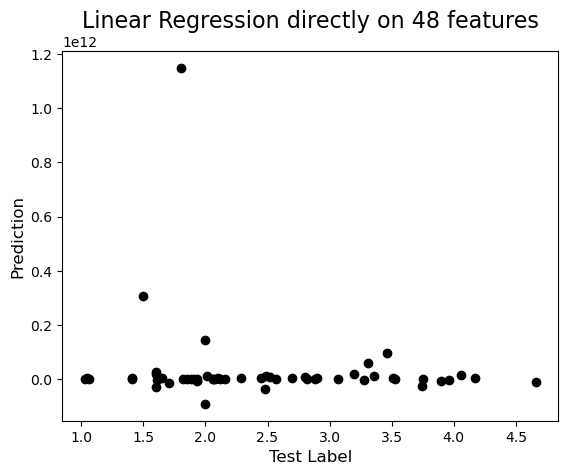

In [93]:
loo = LeaveOneOut(); regr = linear_model.LinearRegression()

x = master_database_wo_duplicates_std[:, :48]
Y = np.array(Bandgap_54x)

real_bandgap = []
results = []

for train_index, test_index in loo.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    regr.fit(X_train, y_train.ravel())
    test_lbl_pred = regr.predict(X_test)
#    print(test_lbl_pred)
    real_bandgap.append(y_test)#[0][0])
    results.append(test_lbl_pred[0])

plt.scatter(real_bandgap, results, color="black")
plt.xlabel('Test Label', fontsize = 12); plt.ylabel('Prediction', fontsize = 12)
plt.title('Linear Regression directly on '+ str(x.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.3f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.3f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.3f" % r2_score(real_bandgap, results))
del[[x, real_bandgap, results, Y]]

In [ ]:
We can see that Linear regres

# Tpot default usage with 32 features:

In [81]:
%%time
import tpot
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=2, random_state=42,
                     #config_dict=tpot_config
                     cv=LeaveOneOut())
#                    )

# uncoment this to run it:
# tpot.fit(X, y)
# print(tpot.score(X, y))
# tpot.export('tpot-64features.py')

CPU times: user 1.64 ms, sys: 624 µs, total: 2.26 ms
Wall time: 1.83 ms


Mean squared error: 0.35
Median absolute error: 0.35
Coefficient of determination: 0.55


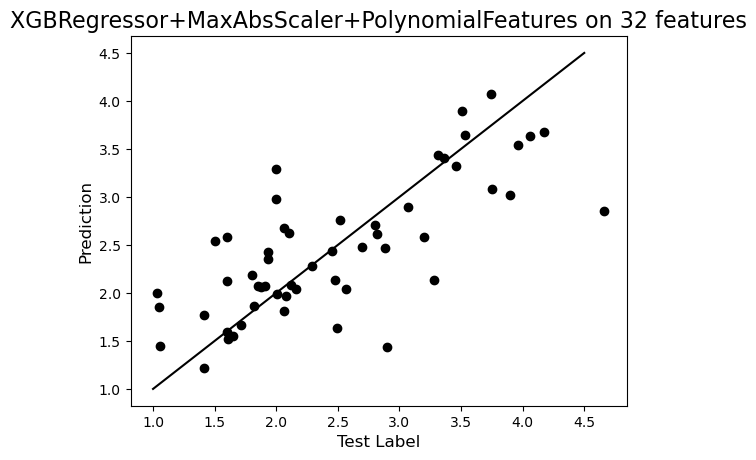

In [72]:
from sklearn.preprocessing import MaxAbsScaler, PolynomialFeatures
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.3520912808444582
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.4, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'XGBRegressor+MaxAbsScaler+PolynomialFeatures'

X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results, y, X]]

Mean squared error: 0.02
Median absolute error: 0.06
Coefficient of determination: 0.98


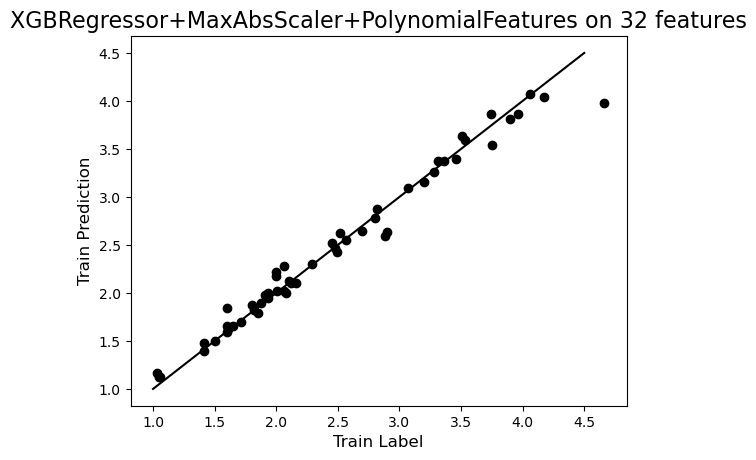

In [74]:
real_bandgap = []
results = []
Model = 'XGBRegressor+MaxAbsScaler+PolynomialFeatures'

X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y]]

# Tpot default usage with descriptor having 64 features

In [32]:
master_database_wo_duplicates.shape

(54, 126)

In [83]:
%%time
import tpot
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X = master_database_wo_duplicates.iloc[:, :64].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     #config_dict=tpot_config
                     cv=LeaveOneOut())
#                    )

# tpot.fit(X_train, y_train)
tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-64features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..

Generation 1 - Current Pareto front scores:

-1	-0.36926923499601766	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=8, XGBRegressor__min_child_weight=3, XG

_pre_test decorator: _random_mutation_operator: num_test=0 [20:43:19] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:792: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000291e64260 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000291f54df0 xgboost::LearnerConfiguration::ConfigureNumFeatures() + 820
  [bt] (2) 3   libxgboost.dylib                    0x0000000291f4a2cc xgboost::LearnerConfiguration::Configure() + 884
  [bt] (3) 4   libxgboost.dylib                    0x0000000291f4a6dc xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x0000000291e6a0d4 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x0000000103b

_pre_test decorator: _random_mutation_operator: num_test=0 [20:50:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:792: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000291e64260 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000291f54df0 xgboost::LearnerConfiguration::ConfigureNumFeatures() + 820
  [bt] (2) 3   libxgboost.dylib                    0x0000000291f4a2cc xgboost::LearnerConfiguration::Configure() + 884
  [bt] (3) 4   libxgboost.dylib                    0x0000000291f4a6dc xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x0000000291e6a0d4 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x0000000103b

Mean squared error: 0.30
Median absolute error: 0.26
Coefficient of determination: 0.61


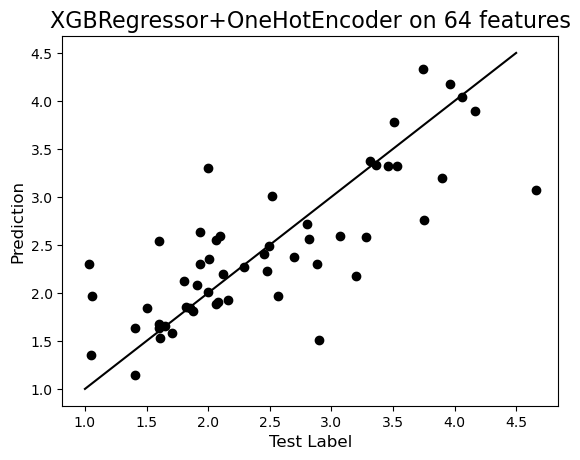

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.builtins import OneHotEncoder
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    OneHotEncoder(minimum_fraction=0.15, sparse=False, threshold=10),
    XGBRegressor(learning_rate=0.5, max_depth=5, min_child_weight=5, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.8, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, :64].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'XGBRegressor+OneHotEncoder'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results, y, X]]

Mean squared error: 0.00
Median absolute error: 0.00
Coefficient of determination: 1.00


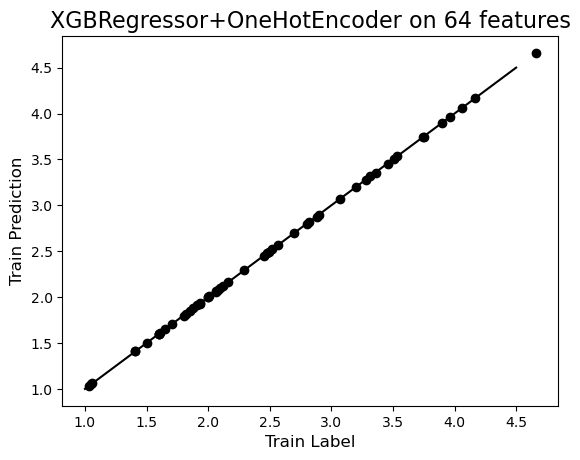

In [89]:
real_bandgap = []
results = []

X = master_database_wo_duplicates.iloc[:, :64].to_numpy()
y = np.array(Bandgap_54x)

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y]]

# Complete search with Tpot

In [85]:
%%time

tpot_config = {

    'sklearn.linear_model.ElasticNetCV': {
        'l1_ratio': np.arange(0.0, 1.01, 0.05),
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },

    'sklearn.ensemble.ExtraTreesRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },

    'sklearn.ensemble.AdaBoostRegressor': {
        'n_estimators': [100],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'loss': ["linear", "square", "exponential"]
    },

    'sklearn.tree.DecisionTreeRegressor': {
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    },

    'sklearn.neighbors.KNeighborsRegressor': {
        'n_neighbors': range(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },

    'sklearn.linear_model.LassoLarsCV': {
        'normalize': [True, False]
    },

    'sklearn.svm.LinearSVR': {
        'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
    },

    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.linear_model.RidgeCV': {
    },

    'xgboost.XGBRegressor': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [1],
        'verbosity': [0],
        'objective': ['reg:squarederror']
    },

    'sklearn.linear_model.SGDRegressor': {
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
        'penalty': ['elasticnet'],
        'alpha': [0.0, 0.01, 0.001] ,
        'learning_rate': ['invscaling', 'constant'] ,
        'fit_intercept': [True, False],
        'l1_ratio': [0.25, 0.0, 1.0, 0.75, 0.5],
        'eta0': [0.1, 1.0, 0.01],
        'power_t': [0.5, 0.0, 1.0, 0.1, 100.0, 10.0, 50.0]
    },

    # Preprocessors
    'sklearn.preprocessing.Binarizer': {
        'threshold': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.decomposition.FastICA': {
        'tol': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.cluster.FeatureAgglomeration': {
        'linkage': ['ward', 'complete', 'average'],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    },

    'sklearn.preprocessing.MaxAbsScaler': {
    },

    'sklearn.preprocessing.MinMaxScaler': {
    },

    'sklearn.preprocessing.Normalizer': {
        'norm': ['l1', 'l2', 'max']
    },

    'sklearn.kernel_approximation.Nystroem': {
        'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
        'gamma': np.arange(0.0, 1.01, 0.05),
        'n_components': range(1, 11)
    },

    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.preprocessing.PolynomialFeatures': {
        'degree': [2],
        'include_bias': [False],
        'interaction_only': [False]
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },

    'tpot.builtins.ZeroCount': {
    },

    'tpot.builtins.OneHotEncoder': {
        'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
        'sparse': [False],
        'threshold': [10]
    },


    # Selectors
    'sklearn.feature_selection.SelectFwe': {
        'alpha': np.arange(0, 0.05, 0.001),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    },

    'sklearn.feature_selection.SelectFromModel': {
        'threshold': np.arange(0, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    }

}

X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     config_dict=tpot_config,
                     cv=LeaveOneOut())

tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-full-search-32-features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization proce

_pre_test decorator: _random_mutation_operator: num_test=0 [21:09:03] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:792: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000291e64260 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000291f54df0 xgboost::LearnerConfiguration::ConfigureNumFeatures() + 820
  [bt] (2) 3   libxgboost.dylib                    0x0000000291f4a2cc xgboost::LearnerConfiguration::Configure() + 884
  [bt] (3) 4   libxgboost.dylib                    0x0000000291f4a6dc xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x0000000291e6a0d4 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x0000000103b

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 48, n_neighbors = 67.

Generation 8 - Current Pareto front scores:

-1	-0.37409046805915525	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=9, XGBRegressor__min_child_weight=3, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.45, XGBRegressor__verbosity=0)

-2	-0.3537731343679859	XGBRegressor(GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.001, GradientBoostingRegressor__loss=quantile, GradientBoostingRegressor__max_depth=1, GradientBoostingRegressor__max_features=0.7000000000000001, GradientBoostingRegressor__min_samples_leaf=19, GradientBoostingRegressor__min_samples_split=20, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.7500000000000001), XGBRegressor__l

Mean squared error: 0.35
Median absolute error: 0.35
Coefficient of determination: 0.55


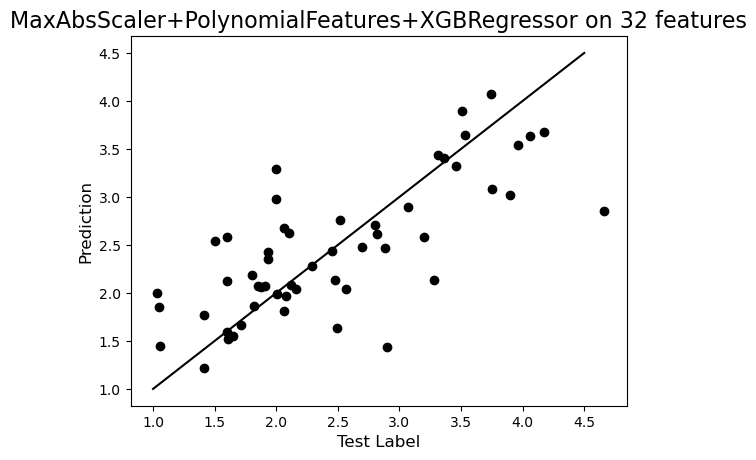

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, PolynomialFeatures
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.4, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)


loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'MaxAbsScaler+PolynomialFeatures+XGBRegressor'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results, y, X]]

Mean squared error: 0.02
Median absolute error: 0.06
Coefficient of determination: 0.98


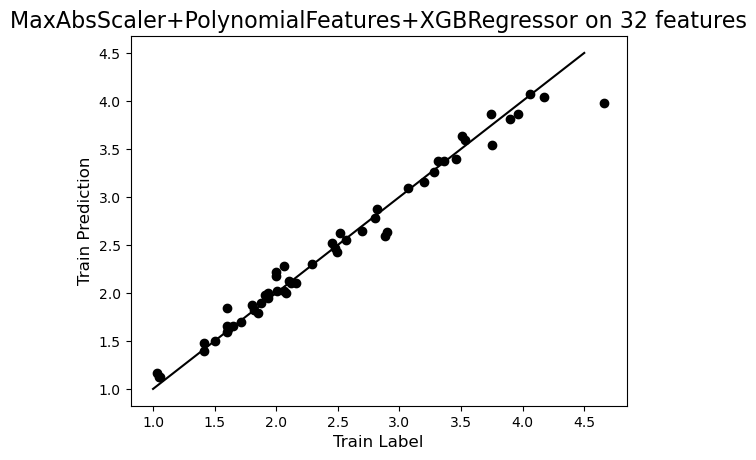

In [97]:
real_bandgap = []
results = []

X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y]]

Old results SVR:

In [ ]:
# regressor = SVR(kernel = 'rbf'); x = x_el_desc
# regressor.fit(x, y['Bandgap'].transpose())
# test_lbl_pred = regressor.predict(x)

# plt.scatter(y, test_lbl_pred, color="black")
# plt.plot([1, 4.5], [1, 4.5], 'k-')
# plt.xlabel('Train Label', fontsize = 12)
# plt.ylabel('Train Prediction', fontsize = 12)
# plt.title('Support Vector Regression on '+ str(x.shape[1]) +' features', fontsize = 16)
# print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
# print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
# print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
# del[[x, regressor, test_lbl_pred]]

In [ ]:
# loo = LeaveOneOut(); Y = np.array(y)
# x = x_el_desc
# regressor = SVR(kernel = 'rbf')

# real_bandgap = []
# results = []

# for train_index, test_index in loo.split(x):
#     X_train, X_test = x[train_index], x[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
    
#     regressor.fit(X_train, y_train.ravel())
#     test_lbl_pred = regressor.predict(X_test)

#     real_bandgap.append(y_test[0][0])
#     results.append(test_lbl_pred[0])

# # Plot outputs
# plt.scatter(real_bandgap, results, color="black")
# plt.plot([1, 4.5], [1, 4.5], 'k-')
# plt.xlabel('Test Label', fontsize = 12)
# plt.ylabel('Prediction', fontsize = 12)
# # plt.xlabel('Train Label', fontsize = 12)
# # plt.ylabel('Prediction', fontsize = 12)
# plt.title('SVR Regression directly on '+ str(x.shape[1]) +' features', fontsize = 16)
# print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
# print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
# print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
# del[[x, real_bandgap, results, Y]]

# Complete search with 48 features

In [98]:
%%time

tpot_config = {

    'sklearn.linear_model.ElasticNetCV': {
        'l1_ratio': np.arange(0.0, 1.01, 0.05),
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },

    'sklearn.ensemble.ExtraTreesRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },

    'sklearn.ensemble.AdaBoostRegressor': {
        'n_estimators': [100],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'loss': ["linear", "square", "exponential"]
    },

    'sklearn.tree.DecisionTreeRegressor': {
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    },

    'sklearn.neighbors.KNeighborsRegressor': {
        'n_neighbors': range(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },

    'sklearn.linear_model.LassoLarsCV': {
        'normalize': [True, False]
    },

    'sklearn.svm.LinearSVR': {
        'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
    },

    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.linear_model.RidgeCV': {
    },

    'xgboost.XGBRegressor': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [1],
        'verbosity': [0],
        'objective': ['reg:squarederror']
    },

    'sklearn.linear_model.SGDRegressor': {
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
        'penalty': ['elasticnet'],
        'alpha': [0.0, 0.01, 0.001] ,
        'learning_rate': ['invscaling', 'constant'] ,
        'fit_intercept': [True, False],
        'l1_ratio': [0.25, 0.0, 1.0, 0.75, 0.5],
        'eta0': [0.1, 1.0, 0.01],
        'power_t': [0.5, 0.0, 1.0, 0.1, 100.0, 10.0, 50.0]
    },

    # Preprocessors
    'sklearn.preprocessing.Binarizer': {
        'threshold': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.decomposition.FastICA': {
        'tol': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.cluster.FeatureAgglomeration': {
        'linkage': ['ward', 'complete', 'average'],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    },

    'sklearn.preprocessing.MaxAbsScaler': {
    },

    'sklearn.preprocessing.MinMaxScaler': {
    },

    'sklearn.preprocessing.Normalizer': {
        'norm': ['l1', 'l2', 'max']
    },

    'sklearn.kernel_approximation.Nystroem': {
        'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
        'gamma': np.arange(0.0, 1.01, 0.05),
        'n_components': range(1, 11)
    },

    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.preprocessing.PolynomialFeatures': {
        'degree': [2],
        'include_bias': [False],
        'interaction_only': [False]
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },

    'tpot.builtins.ZeroCount': {
    },

    'tpot.builtins.OneHotEncoder': {
        'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
        'sparse': [False],
        'threshold': [10]
    },


    # Selectors
    'sklearn.feature_selection.SelectFwe': {
        'alpha': np.arange(0, 0.05, 0.001),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    },

    'sklearn.feature_selection.SelectFromModel': {
        'threshold': np.arange(0, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    }

}

X = master_database_wo_duplicates.iloc[:, :48].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     config_dict=tpot_config,
                     cv=LeaveOneOut())

tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-full-search-48-features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_t

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 48, n_neighbors = 70.
_pre_test decorator: _random_mutation_operator: num_test=0 [22:29:15] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:792: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000291e64260 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000291f54df0 xgboost::LearnerConfiguration::ConfigureNumFeatures() + 820
  [bt] (2) 3   libxgboost.dylib                    0x0000000291f4a2cc xgboost::LearnerConfiguration::Configure() + 884
  [bt] (3) 4   libxgboost.dylib                    0x0000000291f4a6dc xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dyli

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..

Generation 9 - Current Pareto front scores:

-1	-0.349867365245755	XGBRegressor(input_matrix, XGBRegressor__learning_rate=1.0, XGBRegressor__max_depth=3, XGBRegressor__min_child_weight=4, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.8, XGBRegressor__verbosity=0)

-2	-0.3271881835125627	XGBRegressor(XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.001, XGBRegressor__max_depth=2, XGBRegressor__min_child_weight=10, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=1.0, XGBRegressor__verbosity=0), XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=10, XGBRegressor__min_child_weight=5, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegre

Mean squared error: 0.30
Median absolute error: 0.24
Coefficient of determination: 0.62


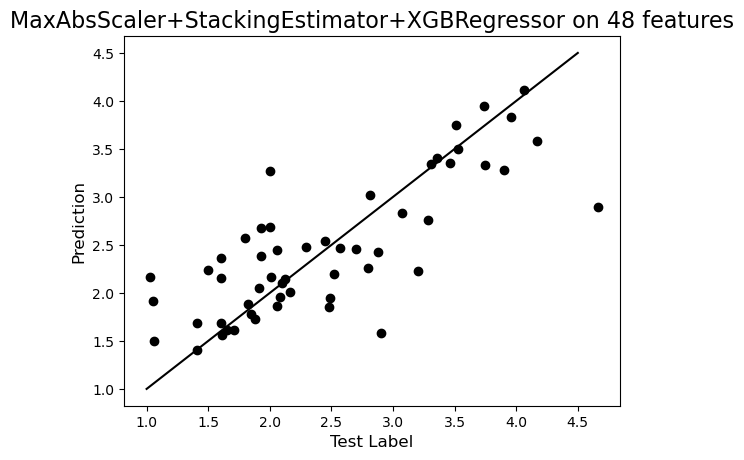

In [105]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MaxAbsScaler
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.29814267152945106
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True, max_features=0.35000000000000003, min_samples_leaf=4, min_samples_split=2, n_estimators=100)),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.4, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)


loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, :48].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'MaxAbsScaler+StackingEstimator+XGBRegressor'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results]]

Mean squared error: 0.02
Median absolute error: 0.07
Coefficient of determination: 0.97


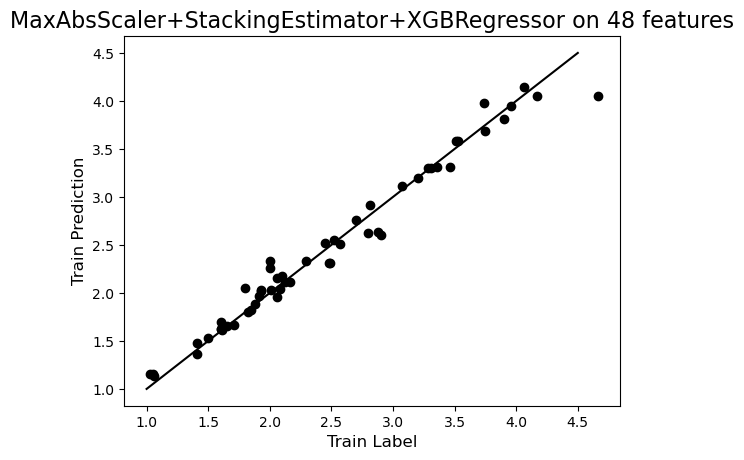

In [106]:
real_bandgap = []
results = []

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y, exported_pipeline, test_lbl_pred]]

# Tpot on just weight comp descriptor

In [159]:
master_database_wo_duplicates.iloc[:, 86:-1].shape

(54, 39)

In [163]:
tpot_config = {

    'sklearn.linear_model.ElasticNetCV': {
        'l1_ratio': np.arange(0.0, 1.01, 0.05),
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },

    'sklearn.ensemble.ExtraTreesRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },

    'sklearn.ensemble.AdaBoostRegressor': {
        'n_estimators': [100],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'loss': ["linear", "square", "exponential"]
    },

    'sklearn.tree.DecisionTreeRegressor': {
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    },

    'sklearn.neighbors.KNeighborsRegressor': {
        'n_neighbors': range(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },

    'sklearn.linear_model.LassoLarsCV': {
        'normalize': [True, False]
    },

    'sklearn.svm.LinearSVR': {
        'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
    },

    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.linear_model.RidgeCV': {
    },

    'xgboost.XGBRegressor': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [1],
        'verbosity': [0],
        'objective': ['reg:squarederror']
    },

    'sklearn.linear_model.SGDRegressor': {
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
        'penalty': ['elasticnet'],
        'alpha': [0.0, 0.01, 0.001] ,
        'learning_rate': ['invscaling', 'constant'] ,
        'fit_intercept': [True, False],
        'l1_ratio': [0.25, 0.0, 1.0, 0.75, 0.5],
        'eta0': [0.1, 1.0, 0.01],
        'power_t': [0.5, 0.0, 1.0, 0.1, 100.0, 10.0, 50.0]
    },

    # Preprocessors
    'sklearn.preprocessing.Binarizer': {
        'threshold': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.decomposition.FastICA': {
        'tol': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.cluster.FeatureAgglomeration': {
        'linkage': ['ward', 'complete', 'average'],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    },

    'sklearn.preprocessing.MaxAbsScaler': {
    },

    'sklearn.preprocessing.MinMaxScaler': {
    },

    'sklearn.preprocessing.Normalizer': {
        'norm': ['l1', 'l2', 'max']
    },

    'sklearn.kernel_approximation.Nystroem': {
        'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
        'gamma': np.arange(0.0, 1.01, 0.05),
        'n_components': range(1, 11)
    },

    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.preprocessing.PolynomialFeatures': {
        'degree': [2],
        'include_bias': [False],
        'interaction_only': [False]
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },

    'tpot.builtins.ZeroCount': {
    },

    'tpot.builtins.OneHotEncoder': {
        'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
        'sparse': [False],
        'threshold': [10]
    },


    # Selectors
    'sklearn.feature_selection.SelectFwe': {
        'alpha': np.arange(0, 0.05, 0.001),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    },

    'sklearn.feature_selection.SelectFromModel': {
        'threshold': np.arange(0, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    }

}

In [164]:
%%time

import tpot
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X = master_database_wo_duplicates.iloc[:, 86:-1].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     config_dict=tpot_config,
                     cv=LeaveOneOut())

tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-weight-39-features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 48, n_neighbors = 49.
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 48, n_neighbors = 83.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.

Generation 1 - Current Pareto front scores:

-1	-0.49248681231044256	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, Rand


Generation 6 - Current Pareto front scores:

-1	-0.4722442371512732	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.5, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=6, RandomForestRegressor__n_estimators=100)

-2	-0.45141474354394323	RandomForestRegressor(DecisionTreeRegressor(input_matrix, DecisionTreeRegressor__max_depth=1, DecisionTreeRegressor__min_samples_leaf=6, DecisionTreeRegressor__min_samples_split=18), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=6, RandomForestRegressor__n_estimators=100)
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penal

Mean squared error: 0.43
Median absolute error: 0.33
Coefficient of determination: 0.45


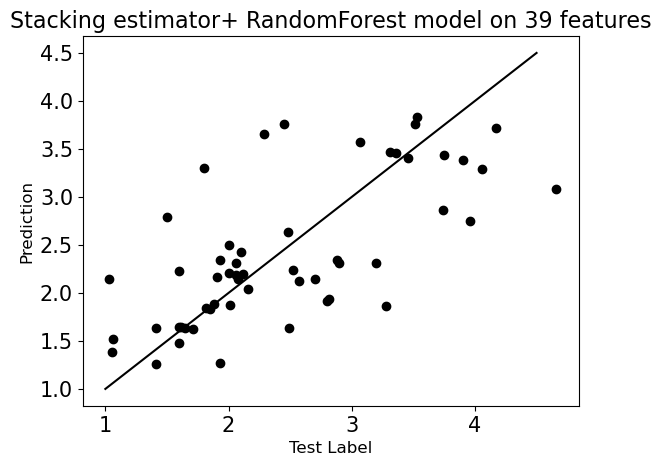

In [199]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=SGDRegressor(alpha=0.01, eta0=0.01, fit_intercept=True, l1_ratio=1.0, learning_rate="invscaling", loss="huber", penalty="elasticnet", power_t=0.1)),
    RandomForestRegressor(bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=1, min_samples_split=6, n_estimators=100)
)

set_param_recursive(exported_pipeline.steps, 'random_state', 42)

loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, 86:-1].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'Stacking estimator+ RandomForest model'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results]]

Mean squared error: 0.048
Median absolute error: 0.066
Coefficient of determination: 0.938


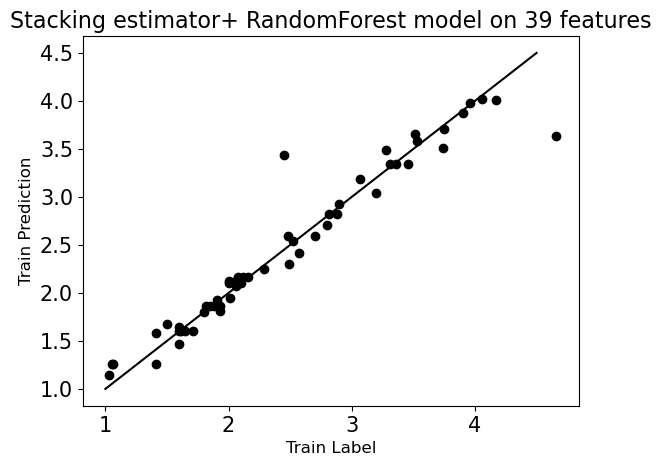

In [200]:
real_bandgap = []
results = []

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.3f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.3f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.3f" % r2_score(y, test_lbl_pred))
del[[X, y, exported_pipeline, test_lbl_pred, real_bandgap, results]]

the same but without 0 features:

In [176]:
%%time

import tpot
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X = master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     config_dict=tpot_config,
                     cv=LeaveOneOut())

tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-weight-30-weight-features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..

Generation 1 - Current Pareto front scores:

-1	-0.5519467929418914	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=8, XGBRegressor__min_child_weight=3, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.4, XGBRegressor__verbosity=0)

-2	-0.5081942321989453	RandomForestRegressor(Normalizer(input_matrix, Normalizer__norm=l1), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.9000000000000001, RandomForestRegressor__min_samples_leaf=1, Rand

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..

Generation 9 - Current Pareto front scores:

-1	-0.5081942321989453	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.9000000000000001, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)

-2	-0.49518075371522674	AdaBoostRegressor(Binarizer(input_matrix, Binarizer__threshold=0.05), AdaBoostRegressor__learning_rate=1.0, AdaBoostRegressor__loss=linear, AdaBoostRegressor__n_estimators=100)

-3	-0.4727832326902392	AdaBoostRegressor(XGBRegressor(Binarizer(input_matrix, Binarizer__threshold=0.05), XGBRegressor__learning_rate=0.5, XGBRegressor__max_depth=6, XGBRegressor__min_chil

Mean squared error: 0.47
Median absolute error: 0.40
Coefficient of determination: 0.39


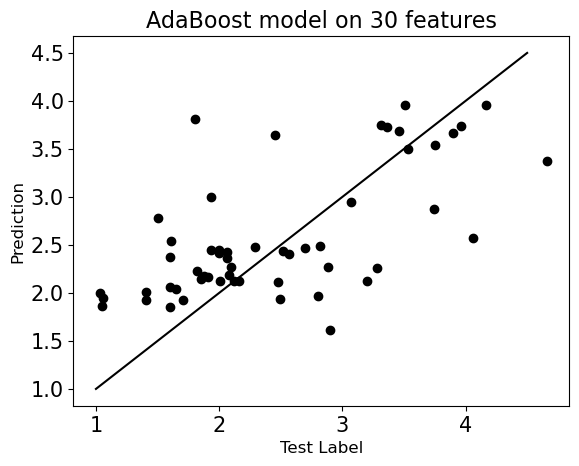

In [195]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Binarizer
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.4727832326902392
exported_pipeline = make_pipeline(
    Binarizer(threshold=0.05),
    StackingEstimator(estimator=XGBRegressor(learning_rate=0.5, max_depth=6, min_child_weight=6, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.3, verbosity=0)),
    AdaBoostRegressor(learning_rate=0.5, loss="square", n_estimators=100)
)
set_param_recursive(exported_pipeline.steps, 'random_state', 42)


loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'AdaBoost model'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results]]

Mean squared error: 0.12
Median absolute error: 0.28
Coefficient of determination: 0.85


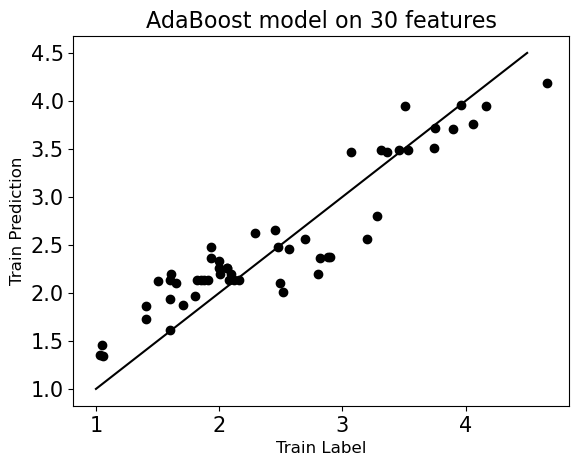

In [196]:
real_bandgap = []
results = []

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y, exported_pipeline, test_lbl_pred, real_bandgap, results]]

if I try the model optimized on also 0s features:

Mean squared error: 0.45
Median absolute error: 0.34
Coefficient of determination: 0.43


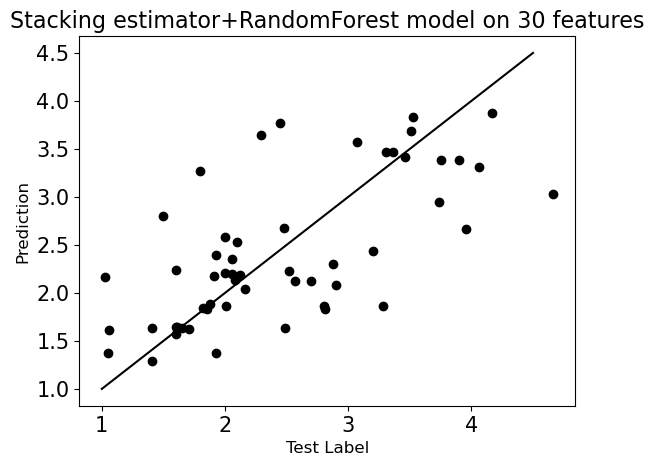

In [193]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=SGDRegressor(alpha=0.01, eta0=0.01, fit_intercept=True, l1_ratio=1.0, learning_rate="invscaling", loss="huber", penalty="elasticnet", power_t=0.1)),
    RandomForestRegressor(bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=1, min_samples_split=6, n_estimators=100)
)

set_param_recursive(exported_pipeline.steps, 'random_state', 42)

loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'Stacking estimator+RandomForest model'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results]]

Mean squared error: 0.049
Median absolute error: 0.071
Coefficient of determination: 0.937


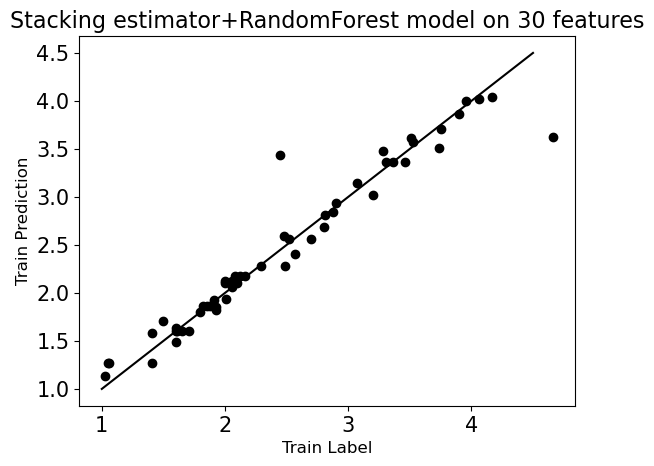

In [194]:
real_bandgap = []
results = []

X = master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].to_numpy()
y = np.array(Bandgap_54x)

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.3f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.3f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.3f" % r2_score(y, test_lbl_pred))
del[[X, y, exported_pipeline, test_lbl_pred, real_bandgap, results]]

# Tpot on elemental + weight comp + sample/crystal info

In [205]:
%%time

X = master_database_wo_duplicates.iloc[:, :-1].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     config_dict=tpot_config,
                     cv=LeaveOneOut())

tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-full-search-125-features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	-0.3566675541761357	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=8, XGBRegressor__min_ch

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 48, n_neighbors = 50.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 7 - Current Pareto front scores:

-1	-0.3566675541761357	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=8, XGBRegressor__min_child_weight=3


Generation 9 - Current Pareto front scores:

-1	-0.3466308659968697	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=6, XGBRegressor__min_child_weight=4, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.5, XGBRegressor__verbosity=0)

-2	-0.30867520811187615	XGBRegressor(DecisionTreeRegressor(input_matrix, DecisionTreeRegressor__max_depth=8, DecisionTreeRegressor__min_samples_leaf=11, DecisionTreeRegressor__min_samples_split=19), XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=8, XGBRegressor__min_child_weight=3, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.4, XGBRegressor__verbosity=0)

-3	-0.3047423141601286	XGBRegressor(VarianceThreshold(DecisionTreeRegressor(input_matrix, DecisionTreeRegressor__max_depth=5, DecisionTreeRegressor__min_samples_leaf=8, DecisionTreeRegressor__min_samples_spl

Mean squared error: 0.30
Median absolute error: 0.22
Coefficient of determination: 0.61


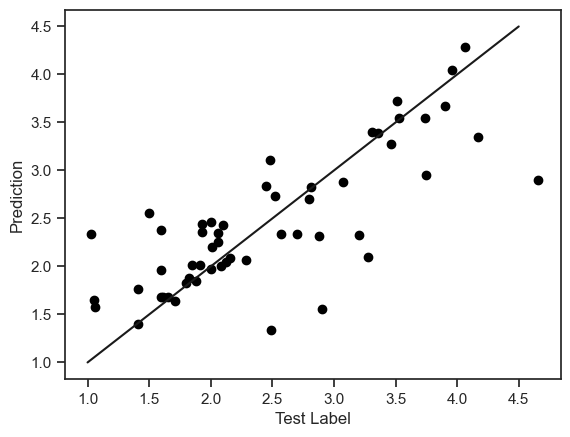

In [219]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeRegressor
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.3047423141601286
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, min_samples_split=13)),
    VarianceThreshold(threshold=0.2),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.4, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, :-1].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'StackingEstimator/DecisionTreeRegressor+VarianceThreshold+XGBRegressor'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
#plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results]]

Mean squared error: 0.03
Median absolute error: 0.06
Coefficient of determination: 0.96


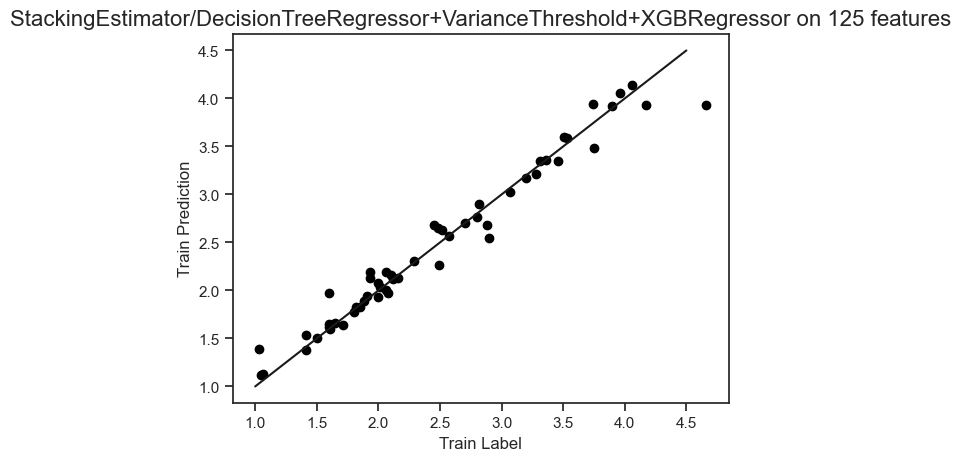

In [220]:
# Average CV score on the training set was: -0.3047423141601286
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, min_samples_split=13)),
    VarianceThreshold(threshold=0.2),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.4, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

real_bandgap = []
results = []

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y, exported_pipeline, test_lbl_pred, real_bandgap, results]]